In [2]:
import torch
print(torch.cuda.is_available())  # 如果返回 True，表示 GPU 可用

True


In [5]:
pip install matplotlib


   ---------------------------------------- 0.0/7.5 MB ? eta -:--:--
   ------------- -------------------------- 2.6/7.5 MB 13.7 MB/s eta 0:00:01
   ---------------------------------------- 7.5/7.5 MB 19.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 1.5/1.5 MB 27.3 MB/s eta 0:00:00


# 執行

In [136]:
import torch

# 設定 ngpu 值
ngpu = torch.cuda.device_count()  # 自動檢測可用 GPU 數量
print(ngpu)

ver='5'

1


In [137]:
# dataset
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch
import torchvision
import random
import torchvision.transforms as transforms
from torch.utils.data import Subset
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils
import torchvision.datasets as dset

# data augmentation
# transforms.Compose將多個數據預處理操作組合成一個管道，按順序應用於每張圖像。

data_transforms =transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ColorJitter(contrast=(1.2, 1.5)),
    transforms.RandomRotation(degrees=60),#隨機旋轉 -30° 到 30° 之間
    transforms.ToTensor(),#將 PIL 圖像或 NumPy 陣列轉換為 PyTorch 的張量（Tensor）。
    transforms.Normalize((0.5,), (0.5,)),
  ])
no_data_transforms =transforms.Compose([
  ])

manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True)

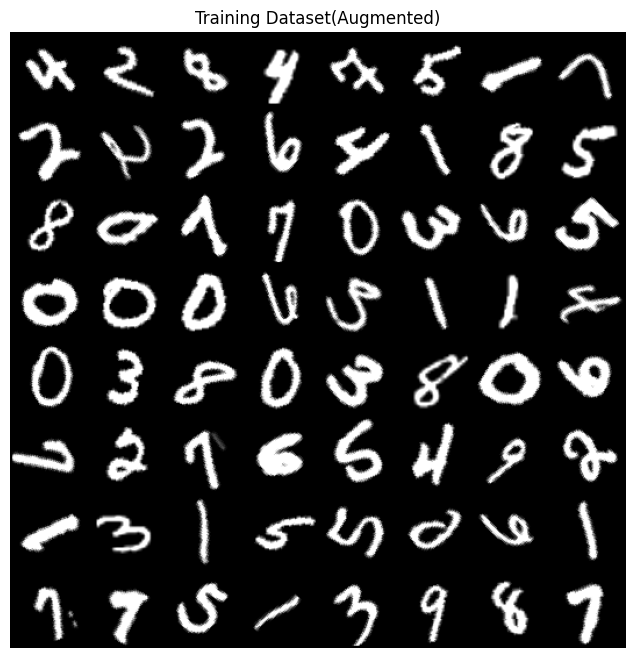

In [138]:
all_dataset=dset.ImageFolder(root=r"D:\CPJ\courses\1131\CvDL\Q2_images\mnist", transform=data_transforms)
dataloader = torch.utils.data.DataLoader(all_dataset, batch_size=64,shuffle=True, num_workers=2)
# Decide which device we want to run on
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Dataset(Augmented)")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device), padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()


In [139]:
import torch.nn as nn

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:  # 初始化所有卷積層
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:  # 初始化所有 BatchNorm 層
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [140]:
import torch.optim as optim
# Learning rate for optimizers
lr = 2e-4 #0.0001
# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5
# Number of channels in the training images. For color images this is 3
nc = 3  #3
# Size of z latent vector (i.e. size of generator input)
nz = 100
# Size of feature maps in generator
ngf = 64
# Size of feature maps in discriminator
ndf = 64

# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device) 

In [141]:
# Generator Code
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

In [142]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html#

In [143]:
netG=Generator(ngpu).to(device)
netG.apply(weights_init)
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [144]:
netD=Discriminator(ngpu).to(device)
netD.apply(weights_init)
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [145]:
# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [146]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
num_epochs=10
min_loss=100
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        #torch.nn.utils.clip_grad_norm_(netD.parameters(), max_norm=1.0)
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1
        if ((errG.item()<min_loss)and(epoch==num_epochs-1)):
            min_loss=errG.item()
            torch.save(netG, r"D:\CPJ\courses\1131\CvDL\Q2_git\netG_ver"+ver+".pth")
            torch.save(netD, r"D:\CPJ\courses\1131\CvDL\Q2_git\netD_ver"+ver+".pth")


Starting Training Loop...
[0/10][0/1094]	Loss_D: 2.0509	Loss_G: 5.8813	D(x): 0.6577	D(G(z)): 0.7450 / 0.0048
[0/10][50/1094]	Loss_D: 0.0416	Loss_G: 5.5603	D(x): 0.9885	D(G(z)): 0.0273 / 0.0074
[0/10][100/1094]	Loss_D: 0.2809	Loss_G: 3.5260	D(x): 0.8351	D(G(z)): 0.0287 / 0.0616
[0/10][150/1094]	Loss_D: 0.1551	Loss_G: 5.9304	D(x): 0.9896	D(G(z)): 0.1256 / 0.0043
[0/10][200/1094]	Loss_D: 0.0592	Loss_G: 4.6319	D(x): 0.9613	D(G(z)): 0.0182 / 0.0147
[0/10][250/1094]	Loss_D: 0.1831	Loss_G: 3.2209	D(x): 0.9043	D(G(z)): 0.0679 / 0.0501
[0/10][300/1094]	Loss_D: 0.0814	Loss_G: 4.1957	D(x): 0.9866	D(G(z)): 0.0626 / 0.0266
[0/10][350/1094]	Loss_D: 0.1123	Loss_G: 4.3231	D(x): 0.9498	D(G(z)): 0.0561 / 0.0184
[0/10][400/1094]	Loss_D: 0.1054	Loss_G: 3.8711	D(x): 0.9469	D(G(z)): 0.0463 / 0.0298
[0/10][450/1094]	Loss_D: 0.1390	Loss_G: 4.8821	D(x): 0.9221	D(G(z)): 0.0459 / 0.0144
[0/10][500/1094]	Loss_D: 0.3134	Loss_G: 4.6912	D(x): 0.9683	D(G(z)): 0.2275 / 0.0132
[0/10][550/1094]	Loss_D: 0.1062	Loss_G: 4.

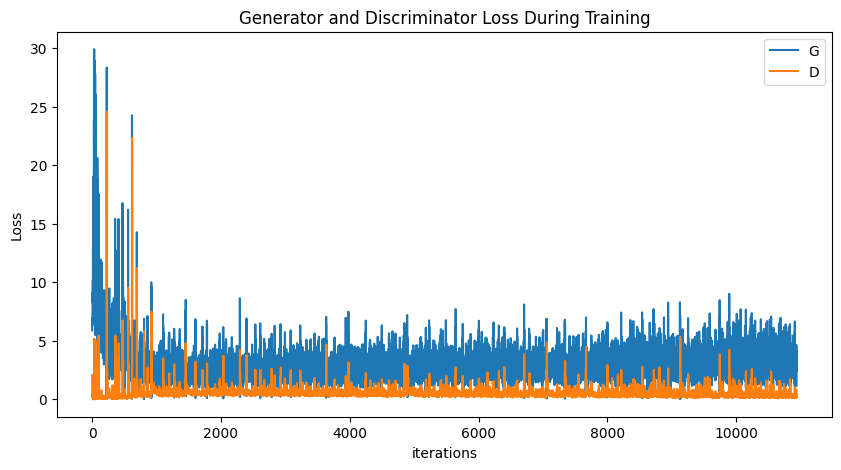

In [147]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig(r"D:\CPJ\courses\1131\CvDL\Q2_git\loss_ver"+ver+".png", dpi=300, bbox_inches="tight")
plt.show()

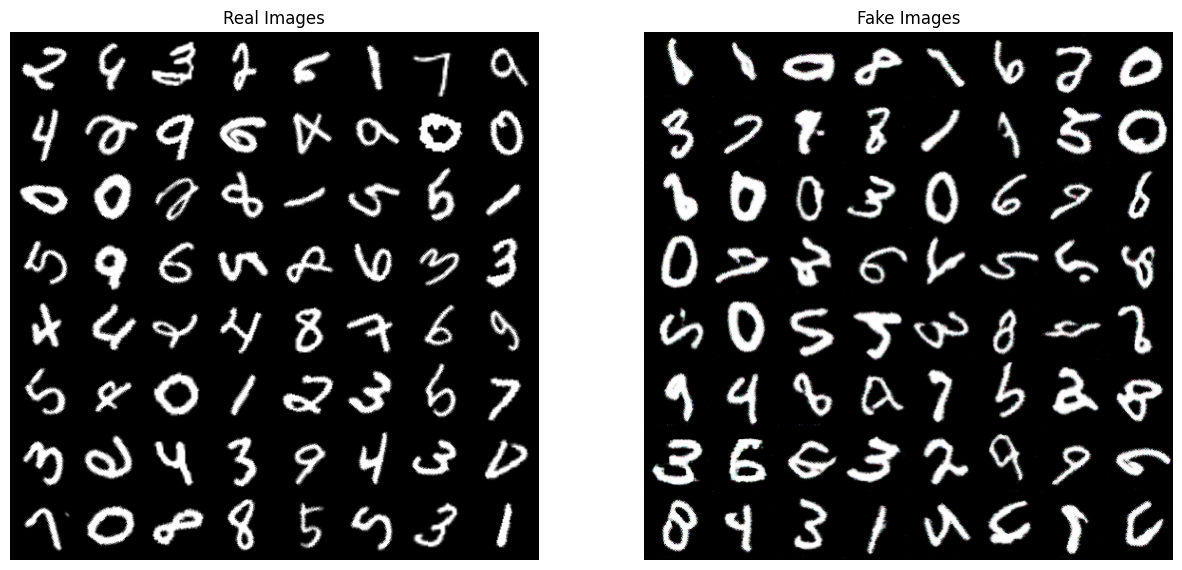

In [148]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1][:64],(1,2,0)))
plt.savefig(r"D:\CPJ\courses\1131\CvDL\Q2_git\real_fake_ver"+ver+".png", dpi=300, bbox_inches="tight")
plt.show()

In [149]:
#for i in img_list:
#   plt.imshow(np.transpose(i,(1,2,0)), animated=True)
#  plt.show()  # 顯示圖片